In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.2.0  Device: cpu


In [2]:
input_size = 32 * 32 * 3
hidden_size = 128
output_size = 10
epoch_size = 50
batch_size = 32
learning_rate = 0.0001

In [3]:
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

# CIFAR 10 dataload
# torchvision에서 여러 데이터를 제공한다. 만약 여기에 없으면 어쩔 수 없이 전처리를 다 해줘야 한다...

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|███████████████████████████████████████████████████████████████▉| 170434560/170498071 [07:35<00:00, 250838.69it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [07:50, 250838.69it/s]                                                                                     

In [10]:
next(iter(trainloader)) 



[tensor([[[[-0.3961, -0.4510, -0.4902,  ..., -0.2471, -0.3647, -0.5294],
           [-0.5059, -0.5137, -0.5059,  ..., -0.2235, -0.3647, -0.4980],
           [-0.5216, -0.5059, -0.4510,  ..., -0.3961, -0.4667, -0.4980],
           ...,
           [-0.2784, -0.2627, -0.2784,  ..., -0.3725, -0.4667, -0.5294],
           [-0.1922, -0.2863, -0.3412,  ..., -0.3961, -0.3882, -0.4745],
           [ 0.3333,  0.0824, -0.1294,  ..., -0.3882, -0.3333, -0.3176]],
 
          [[-0.3255, -0.3725, -0.4118,  ..., -0.2471, -0.4353, -0.6078],
           [-0.4196, -0.4196, -0.4118,  ..., -0.2157, -0.4118, -0.5529],
           [-0.4510, -0.4353, -0.3882,  ..., -0.4275, -0.5373, -0.5686],
           ...,
           [-0.2235, -0.2157, -0.2235,  ..., -0.5451, -0.6471, -0.7098],
           [-0.1608, -0.2549, -0.3098,  ..., -0.5765, -0.5686, -0.6471],
           [ 0.3569,  0.1059, -0.1059,  ..., -0.5686, -0.5137, -0.4902]],
 
          [[-0.1765, -0.2314, -0.2706,  ..., -0.3490, -0.3804, -0.5137],
           [-

In [4]:
trainloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

## Batch Normalization
* 기존의 신경망 성능을 높이려는 시도들이 있어왔다. 대표적으로 input과 weight을 표준화시킨는 것.
* 그러나 문제는 hidden layer가 학습을 진행하면서 input distribution이 불안정해지게 된다.이를 Internal Covariate Shift
라고 한다. 예를 들자면 가족오락관에서 귀마개를 끼고서하는 게임에서 사람을 거칠 수록 이상한 정답이 나오는 이치와 비슷하다고 함. 두 번째 가중치 값이 있다면 이 가중치는 이전 가중치 W1와 입력값에 따라 분포가 달라진다. 즉 W2가 불안정해진다.

1단계
* hidden input -> Batch Normalization -> Activation Funciton 의 구조를 가지면 된다.
* 보통 신경망은 mini batch로 학습하니 각 batch마다 표준화를 시킨다.
* batch_size = m일 때 
* $ {\ μ_β} = {1 \over m} * {\sum_i}X_iW_i  $  (배치 평균)
* $ {\ σ_β} = {1 \over m} * {\sum_i}(X_iW_i - μ_β$)2 (배치 표준편차)
* Activation $ a = f({\ XW_i - μ_β \over \ σ_β})$

2단계
* 그러나 이 상태라면 grdient update에서 bias가 무시된다. sigmoid의 경우 활성화 결과값들이 sigmoid의 중간 선형부분에 위치하게 된다. 이런식으로 나쁜 Normalization을 고칠 감마와 베타라는 파라미터가 추가된다.
* $ {\ a} = γ*({\ XW_i - μ_β \over \ σ_β}) + β $ (이 친구도 마치 또 다른 신경망 같다. 얘네도 학습이 된다는 것)
* 이 값을 실제 신경망의 활성화 함수 입력으로 넣어주면 된다.

Test단계
* 평가 시에는 학습 때 썼던 Batch별 통계값의 평균을 사용하거나 move average를 사용한다.
* $ \hat{\mu} \gets \alpha \hat{\mu} + (1-\alpha) \mu_{\mathcal{B}}^{(i)}$ (알파는 momentum값으로 누구는 0.9를 사용하라고 하고, 파이토치에서는 default가 0.1이다.)
* $ \hat{\sigma} \gets \alpha \hat{\sigma} + (1-\alpha) \sigma_{\mathcal{B}}^{(i)}$


장점


1.   bias 무시 X
2.   hidden input 표준화
3.   vanishing gradient 방지(actiation값을 적당한 크기로 유지)
4.   interval covariate shift 방지
5.   Dropout 안해도 됨. 같은 효과를 내기 떄문이라고 함
6.   Learning Rate 크게 해도 됨 -> 시간단축


텐서플로나 파이토치에서 쉽게 신경망에 추가할 수 있는 클래스를 제공한다.

## 드롭아웃
* 과적합을 막는 방법 중 하나
* 뉴런의 연결을 임의로 삭제
* 단, 테스트 시 모든 노드 사용함.
* 일정 확률로 강력한 뉴런이 무시될 수도 있다. 강력한 뉴런은 학습 데이터에 확신을 가지고 있다는 뜻이고, 그러한 뉴런이 많으면 일반화 능력이 떨어질 수 있다. 

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # input, output
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# Dropout
class DropoutNet(nn.Module):
    def __init__(self):
        super(DropoutNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # input, output
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Batch Normalization
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.bn1(self.linear1(x)))
        x = self.linear2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# 골라서 해보자
# net = Net().to(device)
# net = DropoutNet().to(device)
net = BNNet().to(device)
print(net)

BNNet(
  (linear1): Linear(in_features=3072, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [12]:
performance = {'test_acc': [],'test_loss': []} 

for epoch in range(epoch_size):
    net.train()
    for i, (x, y) in enumerate(trainloader):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    total_label = 0
    correct = 0
    test_loss = 0
    net.eval()
    with torch.no_grad():
        for x, y in testloader:
            images, labels = x.to(device), y.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total_label += labels.size(0)

        test_acc = 100*correct/total_label
        test_loss = test_loss / len(testloader.batch_sampler)
        performance["test_acc"].append(test_acc)
        performance["test_loss"].append(test_loss)

    if epoch % 5 == 0:
        print(f"Epoch: {epoch}, loss: {test_loss:.5f}, acc: {test_acc:.5f}")

170500096it [00:30, 17794713.17it/s]                               

epoch: 0 loss: 52.648 acc: 42.880 
epoch: 5 loss: 45.233 acc: 49.910 
epoch: 10 loss: 42.936 acc: 52.260 
epoch: 15 loss: 42.156 acc: 52.850 
epoch: 20 loss: 42.242 acc: 52.810 
epoch: 25 loss: 42.231 acc: 52.790 
epoch: 30 loss: 42.373 acc: 52.680 
epoch: 35 loss: 42.932 acc: 52.710 
epoch: 40 loss: 44.468 acc: 52.530 
epoch: 45 loss: 44.975 acc: 51.090 


In [ ]:
# 시각화
# 갓대웅님의 시각화 코드 참조 했습니다.
fig = plt.figure()
ax_acc = fig.add_subplot()
ax_acc.plot(range(epoch_size), performance['test_acc'], label='acc', color='darkred')
ax_acc.grid(linestyle='--', color='lavender')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')

ax_loss = ax_acc.twinx()
ax_loss.plot(range(epoch_size), performance['test_loss'], label='loss', color='darkblue')
ax_loss.grid(linestyle='--', color='lavender')
plt.ylabel('Validation Error')
ax_loss.yaxis.tick_right()
plt.show()

* Basic NN
* hidden_size = 128, LR = 0.0001

* 빠르게 과적합하는 모습을 확인할 수 있었습니다.
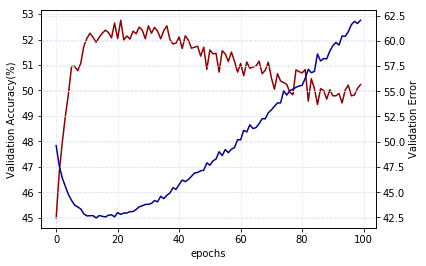

* Dropout
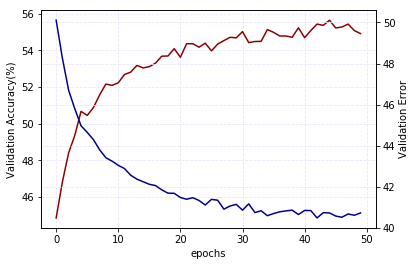

* Batch Normalize
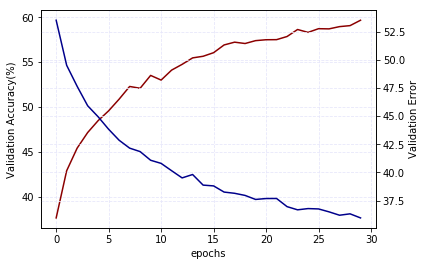
* 60까지 찍어주고 있습니다